<a href="https://colab.research.google.com/github/DogaSahin/Twitter_Sentiment_Analysis/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model & Preparing a proper train/test dataset

In this python notebook we'll get our labeled dataset and train a LSTM network for sentiment analysis and at the end we'll make classifications on the dataset we got from the Twitter.

Kaggle requirements

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip -d sample_data

Importing libraries

In [ ]:
!pip install nltk
%tensorflow_version 1.x

In [ ]:
# Evaluation Metrics
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

# NLP processes
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string

# Tensorlow Libraries
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')

# Data Preprocessing

Loading pre-labeled data

In [ ]:
data = pd.read_csv("sample_data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()


Arranging positive and negative tweets

In [ ]:
# Selecting the text and label coloumn Assigning 1 to Positive sentment 4
data=data[['text','label']]
data['label'][data['label']==4]=1

# Separating positive and negative tweets
positive_data = data[data['label'] == 1]
negative_data = data[data['label'] == 0]

# taking half of the dataset
positive_data = positive_data.iloc[:int(80000)]
negative_data = negative_data.iloc[:int(80000)]

# Combining positive and negative tweets & making all tweets lowercase so we can work better
data = pd.concat([positive_data, negative_data])
data['text']=data['text'].str.lower()

data['text'].head()
data.tail()

Cleaning and removing punctuations


In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

Removing email, URL's & Numeric numbers


In [ ]:
# Cleaning email's from the dataset
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

data['text']= data['text'].apply(lambda x: cleaning_email(x))


# Cleaning URL's from the dataset
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))



# Cleaning numeric symbols from the dataset
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))


# Checking the dataset to see if it's everything okay
data['text'].head()

Cleaning stopwords from the dataset

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

tokenization of tweets

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

Stemming

In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

Applying Lemmatizer

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()


Data splitting and model building

In [ ]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = sequence.pad_sequences(X)
print(X[:2])

max_len = 26

Y = data.label
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

# TENSORFLOW

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer) 
    return model


In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()
history=model.fit(X_train,Y_train,batch_size=80,epochs=15, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 26)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 50)            100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Confusion Matrix



confusion matrix


[[11851  4275]
 [ 3613 12261]]




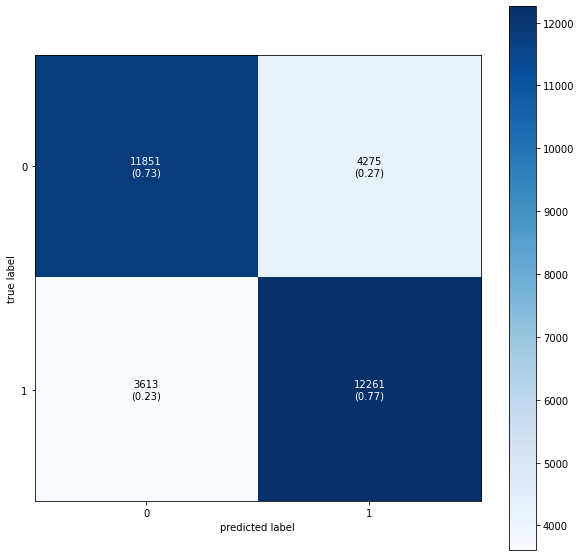

In [ ]:
y_pred = model.predict(X_test) 
y_pred = (y_pred > 0.5) 
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

A quick demonstration of the algorithm to see if it's working properly

In [ ]:
twt = ['covid- 19 getting worse day by day']

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
print(twt)

#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=26, dtype='int32', value=0)
print(twt)

prediction = int(model.predict(twt).round().item())
print(prediction)

[[52, 641, 3, 3]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  52 641   3   3]]
0


# Twitter Data Classification

Loading the data

In [ ]:
test_data = data = pd.read_csv("test.csv", encoding = "ISO-8859-1", engine="python")
print(data.head())

   Unnamed: 0                                               text
0           0  saps cops told theyÃ¢ÂÂll face attempted mur...
1           1  come part august audience join us virtual summ...
2           2  lgbtqi activist verge glory read httpstcobkkcf...
3           3  vaccine progress looking progress countries kn...
4           4  himachalpradesh new covid cases recoveries amp...


Making the predictions

In [ ]:
X=test_data.text

twt = tokenizer.texts_to_sequences(X)
sequences = tokenizer.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(twt, maxlen=26, dtype='int32', value=0)

y_pred = model.predict(X_test)

positives = 0
negatives = 0

for omer in y_pred: # 0.5 is our threshold
  if omer < 0.5:
    negatives += 1
  elif omer > 0.5:
    positives += 1


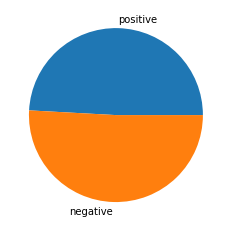

In [ ]:
arr = np.array([positives,negatives])
mylabels = ["positive", "negative"]

plt.pie(arr, labels = mylabels)
plt.show() 